# Weekend movie trip
- EECS 731 Project 3
- Author: Lazarus
- ID : 3028051
 
## Problem Statement
###  Blockbuster or art film?
1. Set up a data science project structure in a new git repository in your GitHub account
2. Download the one of the MovieLens datasets from https://grouplens.org/datasets/movielens/
3. Load the data set into panda data frames
4. Formulate one or two ideas on how the combination of ratings and tags by users helps the data set to establish additional value using exploratory data analysis
5. Build one or more clustering models to determine similar movies to recommend using the other ratings and tags of movies by other users as features
6. Document your process and results
7. Commit your notebook, source code, visualizations and other supporting files to the git repository in GitHub


## Data Description
This dataset (ml-latest-small) describes 5-star rating and free-text tagging activity from http://movielens.org, a movie recommendation service. It contains 100836 ratings and 3683 tag applications across 9742 movies. These data were created by 610 users between March 29, 1996 and September 24, 2018. Users were selected at random for inclusion. All selected users had rated at least 20 movies.Each user is represented by an id and had rated at least 20 movies.
The data are contained in the files `links.csv`, `movies.csv`, `ratings.csv` and `tags.csv`.


## What we want to do?
- Main goal: to use some Clustering models to recommend movies based on ratings and tags by other users.
- First we shall go through dataset and understand what features can we use to best form meaningful clusters.

## Step 1: Lets prepare working environment
- Import all libraries required in the initial stage for data exploration and feature engineering
- Loading data from csv to a pandas dataframe


In [393]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

ratingsdata = pd.read_csv("../data/ratings.csv")
moviesdata = pd.read_csv("../data/movies.csv")
tagsdata = pd.read_csv("../data/tags.csv")

## Step 2: Data Analysis and Feature Engineering

### Let's go through what we have in our data

In [394]:
display(moviesdata.head(5))

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


#### We have three features in 'movies.csv' - movieID which is consistent among all datasets, title and genres. I can see that all three features would help us.

In [395]:
display(tagsdata.head(5))

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


#### We have four features in 'tags.csv' - userID, movieID which are both consistent among all datasets, tag is comments made by users and timestamp represent seconds since midnight Coordinated Universal Time (UTC)

#### We might not be using any of these for now, but tags can be something to work in future work, if we can use sentimental analysis or any other method to analyse these comments and generate a score for each tag by user, that would be very helpful for our recommendation model.

In [396]:
display(ratingsdata.head(5))

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


#### We have four features in 'ratings.csv' - userID, movieID which are again consistent among all datasets, rating are made on a 5-star scale with half-star increments and timestamp represent seconds since midnight Coordinated Universal Time (UTC)

#### Here we have rating which would play a major role in our recommendation model and also we have to figure out if we can use mean of rating for each movie or something else, let us first combine all three datasets, remove missing values and analyse it.

In [397]:
tempdata = pd.merge(ratingsdata,tagsdata,on=['userId','movieId'],how='left')
mergeddata = pd.merge(tempdata,moviesdata,on=['movieId'],how='left').dropna()
mergeddata.head()

,userId,movieId,rating,timestamp_x,tag,timestamp_y,title,genres
241,2,60756,5.0,1445714980,funny,1.445715e+09,Step Brothers (2008),Comedy
242,2,60756,5.0,1445714980,Highly quotable,1.445715e+09,Step Brothers (2008),Comedy
243,2,60756,5.0,1445714980,will ferrell,1.445715e+09,Step Brothers (2008),Comedy
252,2,89774,5.0,1445715189,Boxing story,1.445715e+09,Warrior (2011),Drama
253,2,89774,5.0,1445715189,MMA,1.445715e+09,Warrior (2011),Drama


#### Let's Count the number of movies in each genres

In [398]:
def count_word(df, ref_col, liste):
    keyword_count = dict()
    for s in liste: keyword_count[s] = 0
    for liste_keywords in df[ref_col].str.split('|'):
        if type(liste_keywords) == float and pd.isnull(liste_keywords): continue
        for s in liste_keywords: 
            if pd.notnull(s): keyword_count[s] += 1
    # convert the dictionary in a list to sort the keywords  by frequency
    keyword_occurences = []
    for k,v in keyword_count.items():
        keyword_occurences.append([k,v])
    keyword_occurences.sort(key = lambda x:x[1], reverse = True)
    return keyword_occurences, keyword_count

#### Let's make a set of all genres and count number of occurences using the function 'count_word' we just wrote

In [399]:
genre_labels = set()
for s in mergeddata['genres'].str.split('|').values:
    genre_labels = genre_labels.union(set(s))

keyword_occurences, dum = count_word(mergeddata, 'genres', genre_labels)
display(keyword_occurences)

[['Drama', 2000],
 ['Comedy', 1105],
 ['Thriller', 1065],
 ['Action', 788],
 ['Crime', 779],
 ['Sci-Fi', 641],
 ['Romance', 585],
 ['Adventure', 582],
 ['Mystery', 388],
 ['Fantasy', 283],
 ['Animation', 231],
 ['Horror', 209],
 ['Children', 183],
 ['War', 153],
 ['IMAX', 152],
 ['Musical', 117],
 ['Documentary', 97],
 ['Western', 59],
 ['Film-Noir', 43],
 ['(no genres listed)', 3]]

#### Let's plot this observation to visualize better

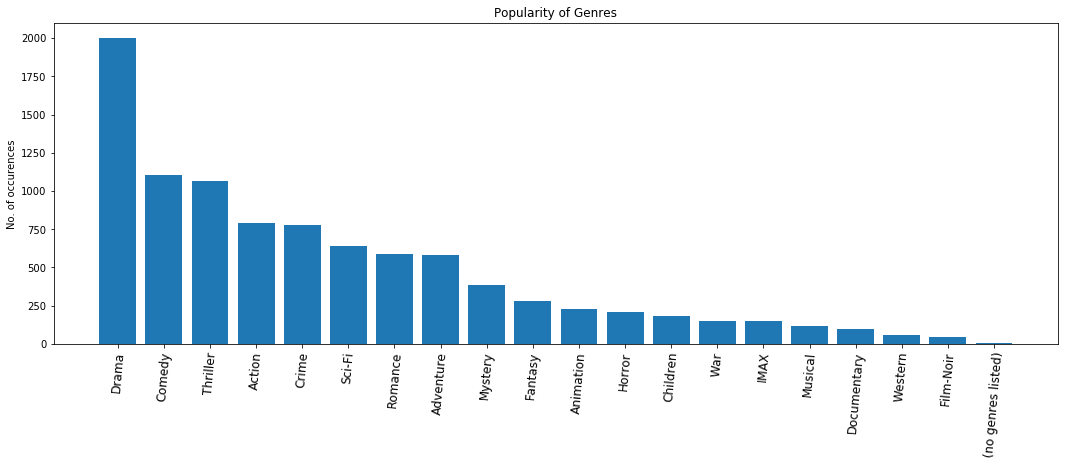

In [400]:
# Graph the Genres vs Occurrences
fig = plt.figure(1, figsize=(18,13))
ax2 = fig.add_subplot(2,1,2)
y_axis = [i[1] for i in keyword_occurences]
x_axis = [k for k,i in enumerate(keyword_occurences)]
x_label = [i[0] for i in keyword_occurences]
plt.xticks(x_axis, x_label)

plt.xticks(rotation=85, fontsize = 12)
plt.ylabel("No. of occurences")
ax2.bar(x_axis, y_axis, align = 'center')
plt.title("Popularity of Genres")
plt.show()

## Let's extract genres from 'genres' feature and make them as features to 'movisedata'

In [401]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
genres_split = moviesdata.genres.str.split('|', expand=True)
genre_columns = np.unique(pd.DataFrame(pd.DataFrame(genres_split.values).values.flatten()).dropna().values.ravel())
genre_columns = np.sort(genre_columns)[::-1]
for g in genre_columns:
    moviesdata.insert(2, g,  [int(g in i) for i in moviesdata.genres.str.split('|', expand=False)], True)
del moviesdata['genres']

In [402]:
display(moviesdata.head(5))

,movieId,title,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


### We have all genres as individual features and if a movie is part of it then the value is 1 and 0 if not. Now, let's add mean and number of ratings for each movie as a new feature

In [403]:
def getAverageRating(movie_id):
    return ratingsdata.loc[ratingsdata['movieId'] == movie_id]['rating'].mean()
def getRatingCount(movie_id):
    return ratingsdata.loc[ratingsdata['movieId'] == movie_id]['rating'].count()

average_ratings = moviesdata['movieId'].map(lambda x: getAverageRating(x))
rating_count = moviesdata['movieId'].map(lambda x: getRatingCount(x))

moviesdata['Rating'] = average_ratings
moviesdata['Num_of_Ratings'] = rating_count

In [404]:
display(moviesdata.head(5))

,movieId,title,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,Rating,Num_of_Ratings
0,1,Toy Story (1995),0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,3.920930,215
1,2,Jumanji (1995),0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,3.431818,110
2,3,Grumpier Old Men (1995),0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,3.259615,52
3,4,Waiting to Exhale (1995),0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,2.357143,7
4,5,Father of the Bride Part II (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,3.071429,49


In [405]:
moviesdata.sort_values(by=['Num_of_Ratings','Rating'], ascending=False, inplace=True)
display(moviesdata.head(5))

,movieId,title,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,Rating,Num_of_Ratings
314,356,Forrest Gump (1994),0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,1,0,4.164134,329
277,318,"Shawshank Redemption, The (1994)",0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,4.429022,317
257,296,Pulp Fiction (1994),0,0,0,0,0,1,1,0,...,0,0,0,0,0,1,0,0,4.197068,307
510,593,"Silence of the Lambs, The (1991)",0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,4.161290,279
1939,2571,"Matrix, The (1999)",0,1,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,4.192446,278


#### It was really important to use 'number of ratings' because for instance some movie might have only 3 ratings of 3, 4 and 3, and other one with 40 ratings with a mean of 3.2, later one should be given precedence because there are more users involved which makes mean more meaningful.

### Let's check and remove all missing values

In [406]:
print("::::::::before:::::::::::")
print(moviesdata.isnull().sum())
moviesdata=moviesdata.dropna()
print("::::::::after::::::::::::")
print(moviesdata.isnull().sum())

::::::::before:::::::::::
movieId                0
title                  0
(no genres listed)     0
Action                 0
Adventure              0
Animation              0
Children               0
Comedy                 0
Crime                  0
Documentary            0
Drama                  0
Fantasy                0
Film-Noir              0
Horror                 0
IMAX                   0
Musical                0
Mystery                0
Romance                0
Sci-Fi                 0
Thriller               0
War                    0
Western                0
Rating                18
Num_of_Ratings         0
dtype: int64
::::::::after::::::::::::
movieId               0
title                 0
(no genres listed)    0
Action                0
Adventure             0
Animation             0
Children              0
Comedy                0
Crime                 0
Documentary           0
Drama                 0
Fantasy               0
Film-Noir             0
Horror                0

### Let us select all genres,  number of rating and mean rating as 'clusterFactors', which can be input for clustering model

In [407]:
clusterFactors = moviesdata.drop(columns=['Num_of_Ratings', 'Rating', 'title', 'movieId'])
display(clusterFactors.head(5))

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
314,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0
277,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0
257,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0
510,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0
1939,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0


## Step 3: Clustering movies and develop recommendation model

### First we will use KMeans Clustering model
- let us find the optimum K value first.
- There is a popular method known as elbow method which is used to determine the optimal value of K to perform the K-Means Clustering Algorithm.

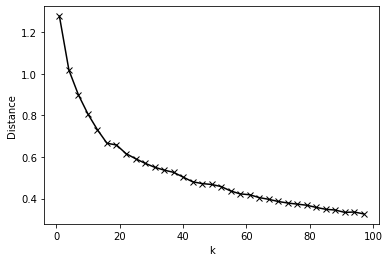

In [408]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
distances = []
K = range(1,100,3)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(clusterFactors)
    kmeanModel.fit(clusterFactors)
    distances.append(sum(np.min(cdist(clusterFactors, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / clusterFactors.shape[0])

# Plot the elbow graph
plt.plot(K, distances, 'kx-')
plt.xlabel('k')
plt.ylabel('Distance')
plt.show()

### The basic idea behind this method is that it plots the various values of cost with changing k. As the value of K increases, there will be fewer elements in the cluster. We can see from the plot that we have optimal k value as 20. Let's use 20 and train the model


In [409]:
kmeans = KMeans(n_clusters=20).fit_predict(clusterFactors)
moviesdata['KMeanCluster'] = kmeans

## Now let us sort our dataframe over 'KMeanCluster' , 'Num of ratings' and 'Rating'

In [410]:
moviesdata.sort_values(by=['KMeanCluster','Num_of_Ratings', 'Rating'], ascending=False, inplace=True)
display(moviesdata.head())

,movieId,title,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,Rating,Num_of_Ratings,KMeanCluster
46,50,"Usual Suspects, The (1995)",0,0,0,0,0,0,1,0,...,0,1,0,0,1,0,0,4.237745,204,19
509,592,Batman (1989),0,1,0,0,0,0,1,0,...,0,0,0,0,1,0,0,3.428571,189,19
793,1036,Die Hard (1988),0,1,0,0,0,0,1,0,...,0,0,0,0,1,0,0,3.862069,145,19
138,165,Die Hard: With a Vengeance (1995),0,1,0,0,0,0,1,0,...,0,0,0,0,1,0,0,3.555556,144,19
828,1089,Reservoir Dogs (1992),0,0,0,0,0,0,1,0,...,0,1,0,0,1,0,0,4.202290,131,19


## Lets write a function to find 5 similar movies with KMean Clusters

In [411]:
def findSimilarMovie(movieTitle):
    cluster = moviesdata.loc[moviesdata['title'] == movieTitle]['KMeanCluster'].values[0]
    cluster_movies = moviesdata.loc[moviesdata['KMeanCluster'] == cluster]
    return pd.DataFrame(cluster_movies['title'].values).head(5).values.tolist()
findSimilarMovie('Toy Story (1995)')

[['Toy Story (1995)'],
 ['Lord of the Rings: The Fellowship of the Ring, The (2001)'],
 ['Lord of the Rings: The Two Towers, The (2002)'],
 ['Lion King, The (1994)'],
 ['Shrek (2001)']]

In [412]:
findSimilarMovie('Titanic (1997)')

[['American Beauty (1999)'],
 ['Good Will Hunting (1997)'],
 ['Titanic (1997)'],
 ['Eternal Sunshine of the Spotless Mind (2004)'],
 ['Beautiful Mind, A (2001)']]

### We have a successful movie recommender based on Kmeans Clustering

## Let's try Agglomerative Clustering 

In [413]:
from sklearn.cluster import AgglomerativeClustering
agglomerative_clustering = AgglomerativeClustering(n_clusters=20).fit_predict(clusterFactors)
moviesdata['AgglomerativeClustering'] = agglomerative_clustering
moviesdata.sort_values(by=['AgglomerativeClustering', 'Num_of_Ratings', 'Rating'], inplace=True, ascending=False)

### We will write a similar movie recommender funciton based on Agglomerative Clustering

In [414]:
def findSimilarMovieAC(movieTitle):
    cluster = moviesdata.loc[moviesdata['title'] == movieTitle]['AgglomerativeClustering'].values[0]
    cluster_movies = moviesdata.loc[moviesdata['AgglomerativeClustering'] == cluster]
    return pd.DataFrame(cluster_movies['title'].values).head(5).values.tolist()

In [415]:
findSimilarMovieAC('Toy Story (1995)')

[['Terminator 2: Judgment Day (1991)'],
 ['Toy Story (1995)'],
 ['Mask, The (1994)'],
 ['Beauty and the Beast (1991)'],
 ['Inception (2010)']]

In [416]:
findSimilarMovie('Titanic (1997)')

[['Beautiful Mind, A (2001)'],
 ['Rob Roy (1995)'],
 ['Pearl Harbor (2001)'],
 ['Bodyguard, The (1992)'],
 ['About Time (2013)']]

## We have another successful recommender based on Agglomerative Clustering

## Now let us plot these clusters

Text(0.5, 0, 'Movie Id')

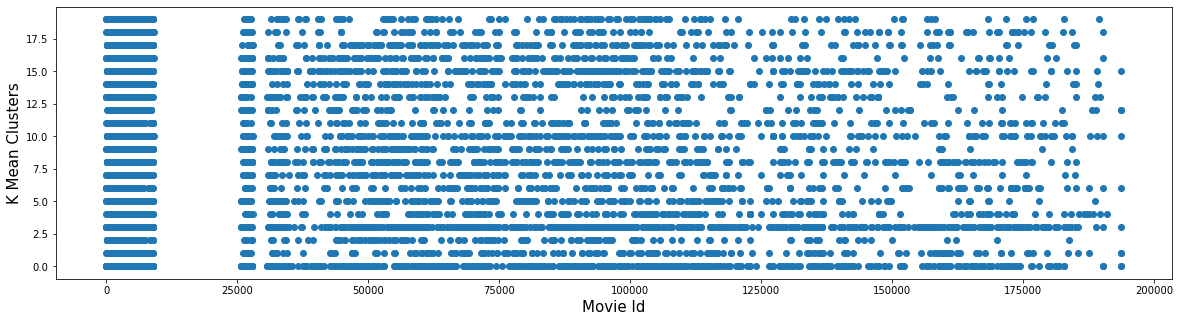

In [417]:
plt.figure(figsize=(20,5))
plt.scatter(moviesdata['movieId'], moviesdata['KMeanCluster'])

plt.ylabel("K Mean Clusters", fontsize= 15)
plt.xlabel("Movie Id", fontsize= 15)

Text(0.5, 0, 'Movie Id')

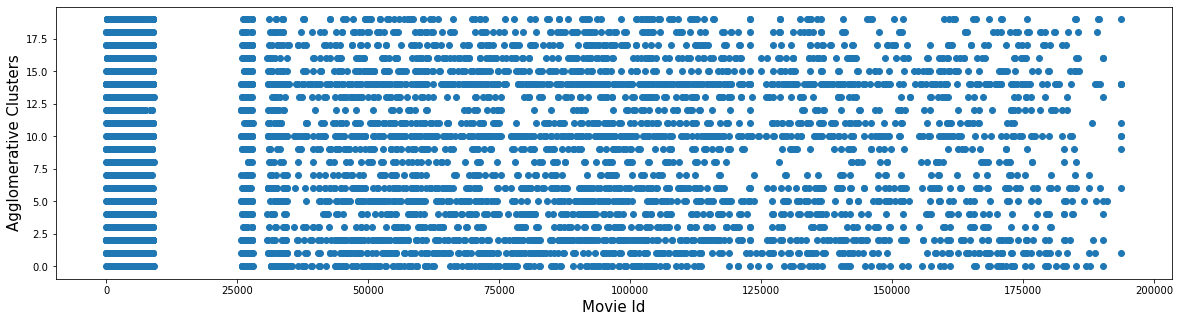

In [418]:
plt.figure(figsize=(20,5))
plt.scatter(moviesdata['movieId'], moviesdata['AgglomerativeClustering'])

plt.ylabel("Agglomerative Clusters", fontsize= 15)
plt.xlabel("Movie Id", fontsize= 15)

## Conclusions and further improvements:

- We can get more meaningful recommendations if we could use tags and score them for clustering
- Also I'm not sure if that would improve but we can try combinations of multiple clustering models to recommend movies.